---
format: 
  html:
    toc: false
    page-layout: full
execute:
    echo: false
---

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
import hvplot.pandas

np.random.seed(42)

In [2]:
pd.options.display.max_columns = 999

# BUILDING THE PREDICTIVE MODEL

In [3]:
# Models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Model selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Pipelines
from sklearn.pipeline import make_pipeline

# Preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

## HOUSING SALES DATA

In [4]:
#| echo: true 
#| code-fold: true

# the CARTO API url
carto_url = "https://phl.carto.com/api/v2/sql"

# Only pull 2022 sales for single family residential properties
where = "sale_date >= '2022-01-01' and sale_date <= '2022-12-31'"
where = where + " and category_code_description IN ('SINGLE FAMILY', 'Single Family')"

# Create the query
query = f"SELECT * FROM opa_properties_public WHERE {where}"

# Make the request
params = {"q": query, "format": "geojson"}
response = requests.get(carto_url, params=params)

# Make the GeoDataFrame
salesRaw = gpd.GeoDataFrame.from_features(response.json(), crs="EPSG:4326")

# Optional: put it a reproducible order for test/training splits later
salesRaw = salesRaw.sort_values("parcel_number")

#### Selecting Columns, Remove NaN Value, Remove Very High and Very Low Sales Prices

In [10]:
#| echo: true 
#| code-fold: true

# The feature columns we want to use
cols = [
    "sale_price",
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "frontage",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "exterior_condition",
    "interior_condition",
    "zip_code",
    "garage_type",
    "zoning"
]

# Trim to these columns and remove NaNs
sales = salesRaw[cols + ["geometry"]].dropna()

# Trim zip code to only the first five digits
sales["zip_code"] = sales["zip_code"].astype(str).str.slice(0, 5)

# Trim very low and very high sales
valid = (sales['sale_price'] > 3000) & (sales['sale_price'] < 1e6)
sales = sales.loc[valid]

In [12]:
len(sales);

#### Split the data into training and test set (70/30)

In [14]:
#| echo: true
#| code-fold: true
# Split the data 70/30
train_set, test_set = train_test_split(sales, test_size=0.3, random_state=42)

# the target labels: log of sale price
y_train = np.log(train_set["sale_price"])
y_test = np.log(test_set["sale_price"])

#### Selecting Numerical Features:
"total_livable_area", "total_area", "garage_spaces", "fireplaces", "frontage", "number_of_bathrooms", "number_of_bedrooms", "number_stories"

In [18]:
# The features
feature_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "frontage",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
]
X_train = train_set[feature_cols].values
X_test = test_set[feature_cols].values

### Score of a linear regression model as a baseline:

In [19]:
#| echo: true
#| code-fold: true
# Make a linear model pipeline
linear_pipeline = make_pipeline(StandardScaler(), LinearRegression())

# Fit on the training data
linear_pipeline.fit(X_train, y_train)

# What's the test score?
linear_pipeline.score(X_test, y_test)

0.48149900155901426

### Result of cross-validation on a random forest model:

In [20]:
#| echo: true
#| code-fold: true
# Make a random forest pipeline
forest_pipeline = make_pipeline(
    StandardScaler(), RandomForestRegressor(n_estimators=100, random_state=42)
)

# Run the 10-fold cross validation
scores = cross_val_score(
    forest_pipeline,
    X_train,
    y_train,
    cv=10,
)

# Report
print("R^2 scores = ", scores)
print("Scores mean = ", scores.mean())
print("Score std dev = ", scores.std())

R^2 scores =  [0.527394   0.49451605 0.6344734  0.55960568 0.59060613 0.54684389
 0.60374838 0.44244995 0.50146811 0.47442473]
Scores mean =  0.5375530322895475
Score std dev =  0.05783592441257988


### Score of random forest model:

In [103]:
#| echo: true
#| code-fold: true
# Fit on the training data
forest_pipeline.fit(X_train, y_train)

# What's the test score?
forest_pipeline.score(X_test, y_test)

0.6255116826480132

In [17]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#### Set Up Transformer for Numerical and categorical columns:

In [18]:
# Numerical columns
num_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "frontage",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
]

# Categorical columns
cat_cols = ["exterior_condition","interior_condition","zip_code","garage_type","zoning"]

In [23]:
#| echo: true
#| code-fold: true
# Set up the column transformer with two transformers
# ----> Scale the numerical columns
# ----> One-hot encode the categorical columns

transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# Initialize the pipeline
# NOTE: only use 10 estimators here so it will run in a reasonable time
pipe = make_pipeline(
    transformer, RandomForestRegressor(n_estimators=10, 
                                       random_state=42)
)

# Fit the training set
pipe.fit(train_set, y_train);

### Test Score of pipe model:

In [24]:
# What's the test score?
pipe.score(test_set, y_test)

0.7430072213389314

## Adding spatial features (distance-based) to the housing price model

- Adding spatial amenity/disamenity features (311 Request, Crime Incidents, Open Street Map)

### FEATURE 1: 311 GRAFFITI CALLS

In [92]:
from sklearn.neighbors import NearestNeighbors

In [93]:
#| echo: true
#| code-fold: true
def get_carto_data(table_name, where=None, limit=None):
    """
    Download data from CARTO given a specific table name and
    optionally a where statement or limit.
    """

    # the CARTO API url
    carto_url = "https://phl.carto.com/api/v2/sql"

    # Create the query
    query = f"SELECT * FROM {table_name}"

    # Add a where
    if where is not None:
        query = query + f" WHERE {where}"

    # Add a limit
    if limit is not None:
        query = query + f" LIMIT {limit}"

    # Make the request
    params = {"q": query, "format": "geojson"}
    response = requests.get(carto_url, params=params)

    # Make the GeoDataFrame
    return gpd.GeoDataFrame.from_features(response.json(), crs="EPSG:4326")

table_name = "public_cases_fc"

get_carto_data(table_name, limit=5);

# Select only those for grafitti and in 2022
where = "requested_datetime >= '01-01-2022' and requested_datetime < '01-01-2023'"
where = where + " and service_name = 'Graffiti Removal'"

# Pull the subset we want
graffiti = get_carto_data(table_name, where=where)

# Remove rows with empty or NaN geometries
not_missing = (~graffiti.geometry.is_empty) & (graffiti.geometry.notna())
graffiti = graffiti.loc[not_missing]

len(graffiti);

# Do the CRS conversion
sales_3857 = sales.to_crs(epsg=3857)
graffiti_3857 = graffiti.to_crs(epsg=3857)

def get_xy_from_geometry(df):
    """
    Return a numpy array with two columns, where the 
    first holds the `x` geometry coordinate and the second 
    column holds the `y` geometry coordinate
    """
    x = df.geometry.x
    y = df.geometry.y
    
    return np.column_stack((x, y)) # stack as columns

# Extract x/y for sales
salesXY = get_xy_from_geometry(sales_3857)

# Extract x/y for grafitti calls
graffitiXY = get_xy_from_geometry(graffiti_3857)

salesXY.shape

graffitiXY.shape;

# STEP 1: Initialize the algorithm
k = 5
nbrs = NearestNeighbors(n_neighbors=k)

# STEP 2: Fit the algorithm on the "neighbors" dataset
nbrs.fit(graffitiXY)

# STEP 3: Get distances for sale to neighbors
grafDists, grafIndices = nbrs.kneighbors(salesXY) 

# The distances from the first sale to the 5 nearest neighbors
grafDists[0];

grafIndices[0];

salesXY[0];

# The coordinates for the first sale
x0, y0 = salesXY[0]
x0, y0;

# The indices for the 5 nearest graffiti calls
grafIndices[0];

# the graffiti neighbors
sale0_neighbors = graffitiXY[grafIndices[0]]
sale0_neighbors;

# Access the first and second column for x/y values
neighbors_x = sale0_neighbors[:,0]
neighbors_y = sale0_neighbors[:,1]

# The x/y differences between neighbors and first sale coordinates
dx = (neighbors_x - x0)
dy = (neighbors_y - y0)

# The Euclidean dist
manual_dists = (dx**2 + dy**2) ** 0.5

manual_dists;

grafDists[0];

grafDists.mean(axis=1);

# Average distance to neighbors
avgGrafDist = grafDists.mean(axis=1)

# Set zero distances to be small, but nonzero
# IMPORTANT: THIS WILL AVOID INF DISTANCES WHEN DOING THE LOG
avgGrafDist[avgGrafDist==0] = 1e-5

# Calculate log of distances
sales['logDistGraffiti'] = np.log10(avgGrafDist)

In [95]:
sales.head();

In [65]:
# Load the City Limits from OpenDataPhilly's page
url = "https://opendata.arcgis.com/datasets/405ec3da942d4e20869d4e1449a2be48_0.geojson"
city_limits = gpd.read_file(url).to_crs(epsg=3857)

### FEATURE 2: SUBWAY STOPS

In [70]:
import osmnx as ox

In [71]:
city_limits.to_crs(epsg=4326).squeeze().geometry;

In [72]:
# Get the geometry from the city limits
city_limits_outline = city_limits.to_crs(epsg=4326).squeeze().geometry

city_limits_outline;

In [76]:
#| echo: true
#| code-fold: true

# Get the subway stops within the city limits
subway = ox.features_from_polygon(city_limits_outline, tags={"station": "subway"})

# Convert to 3857 (meters)
subway = subway.to_crs(epsg=3857)

# STEP 1: x/y coordinates of subway stops (in EPGS=3857)
subwayXY = get_xy_from_geometry(subway.to_crs(epsg=3857))

# STEP 2: Initialize the algorithm
nbrs = NearestNeighbors(n_neighbors=1)

# STEP 3: Fit the algorithm on the "neighbors" dataset
nbrs.fit(subwayXY)

# STEP 4: Get distances for sale to neighbors
subwayDists, subwayIndices = nbrs.kneighbors(salesXY)

# STEP 5: add back to the original dataset
sales["logDistSubway"] = np.log10(subwayDists.mean(axis=1))

In [77]:
def get_xy_from_geometry(df):
    """
    Return a numpy array with two columns, where the 
    first holds the `x` geometry coordinate and the second 
    column holds the `y` geometry coordinate
    """
    # NEW: use the centroid.x and centroid.y to support Polygon() and Point() geometries 
    x = df.geometry.centroid.x
    y = df.geometry.centroid.y
    
    return np.column_stack((x, y)) # stack as columns

### FEATURE 3: DISTANCE TO UNIVERSITIES

In [78]:
#| echo: true
#| code-fold: true

# Get the data
url = "https://opendata.arcgis.com/api/v3/datasets/8ad76bc179cf44bd9b1c23d6f66f57d1_0/downloads/data?format=geojson&spatialRefId=4326"
univs = gpd.read_file(url)

# Get the X/Y
univXY = get_xy_from_geometry(univs.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(univXY)
univDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales['logDistUniv'] = np.log10(univDists.mean(axis=1))

### FEATURE 4: DISTANCE TO PARK

In [80]:
#| echo: true
#| code-fold: true
# Get the data
url = "https://opendata.arcgis.com/datasets/d52445160ab14380a673e5849203eb64_0.geojson"
parks = gpd.read_file(url)

# Get the X/Y
parksXY = get_xy_from_geometry(parks.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(parksXY)
parksDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales["logDistParks"] = np.log10(parksDists.mean(axis=1))

### FEATURE 5: DISTANCE TO CITY HALL

In [82]:
#| echo: true
#| code-fold: true
# Get the data
url = "http://data-phl.opendata.arcgis.com/datasets/5146960d4d014f2396cb82f31cd82dfe_0.geojson"
landmarks = gpd.read_file(url)

# Trim to City Hall
cityHall = landmarks.query("NAME == 'City Hall' and FEAT_TYPE == 'Municipal Building'")

# Get the X/Y
cityHallXY = get_xy_from_geometry(cityHall.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=1)
nbrs.fit(cityHallXY)
cityHallDist, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales["logDistCityHall"] = np.log10(cityHallDist.mean(axis=1))

### FEATURE 6: DISTANCE TO 5 NEAREST RESIDENTIAL CONSTRUCTION PERMITS FROM 2022

In [86]:
#| echo: true
#| code-fold: true

import warnings

# Table name
table_name = "permits"

# Where clause
where = "permitissuedate >= '2022-01-01' AND permitissuedate < '2023-01-01'"
where = where + " AND permitdescription='RESIDENTIAL BUILDING PERMIT'"

# Suppress warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    # Query
    permits = get_carto_data(table_name, where=where)

    # Remove missing
    not_missing = ~permits.geometry.is_empty & permits.geometry.notna()
    permits = permits.loc[not_missing]

    # Get the X/Y
    permitsXY = get_xy_from_geometry(permits.to_crs(epsg=3857))

    # Run the k nearest algorithm
    nbrs = NearestNeighbors(n_neighbors=5)
    nbrs.fit(permitsXY)
    permitsDist, _ = nbrs.kneighbors(salesXY)

    # Add the new feature
    sales["logDistPermits"] = np.log10(permitsDist.mean(axis=1))

### FEATURE 7: DISTANCE TO THE 5 NEAREST AGGRAVATED ASSAULT IN 2022

In [87]:
#| echo: true
#| code-fold: true

# Table name
table_name = "incidents_part1_part2"

# Where selection
where = "dispatch_date >= '2022-01-01' AND dispatch_date < '2023-01-01'"
where = where + " AND Text_General_Code IN ('Aggravated Assault No Firearm', 'Aggravated Assault Firearm')"

# Query
assaults = get_carto_data(table_name, where=where)

# Remove missing 
not_missing = ~assaults.geometry.is_empty & assaults.geometry.notna()
assaults = assaults.loc[not_missing]
    
# Get the X/Y
assaultsXY = get_xy_from_geometry(assaults.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(assaultsXY)
assaultDists, _ = nbrs.kneighbors(salesXY)

# Add the new feature
sales['logDistAssaults'] = np.log10(assaultDists.mean(axis=1))

### FEATURE 8: DISTANCE TO THE 5 NEAREST ABANDONED VEHICLE 311 CALLS IN 2022

In [89]:
#| echo: true
#| code-fold: true
# Table name
table_name = "public_cases_fc"

# Where selection
where = "requested_datetime >= '2022-01-01' AND requested_datetime < '2023-01-01'"
where = "service_name = 'Abandoned Vehicle'"

# Query
cars = get_carto_data(table_name, where=where)

# Remove missing
not_missing = ~cars.geometry.is_empty & cars.geometry.notna()
cars = cars.loc[not_missing]

# Get the X/Y
carsXY = get_xy_from_geometry(cars.to_crs(epsg=3857))

# Run the k nearest algorithm
nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(carsXY)
carDists, _ = nbrs.kneighbors(salesXY)

# Handle any sales that have 0 distances
carDists[carDists == 0] = 1e-5  # a small, arbitrary value

# Add the new feature
sales["logDistCars"] = np.log10(carDists.mean(axis=1))

### FEATURE 9: DISTANCE TO THE 5 NEAREST HOMELESS ENCAMPMENT REQUEST IN 2022

In [91]:
#| echo: true
#| code-fold: true

import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.neighbors import NearestNeighbors

# Assuming salesXY is your input data
# Step 1: Impute NaN values
imputer = SimpleImputer(strategy='mean')
salesXY_imputed = imputer.fit_transform(salesXY)

# Step 2: Continue with the rest of your code
table_name = "public_cases_fc"
where = "requested_datetime >= '2022-01-01' AND requested_datetime < '2023-01-01'"
where = "service_name = 'Homeless Encampment Request'"

encampment = get_carto_data(table_name, where=where)

not_missing = ~encampment.geometry.is_empty & encampment.geometry.notna()
encampment = encampment.loc[not_missing]

encampmentXY = get_xy_from_geometry(encampment.to_crs(epsg=3857))

nbrs = NearestNeighbors(n_neighbors=5)
nbrs.fit(encampmentXY)

encampmentDists, _ = nbrs.kneighbors(salesXY_imputed)

encampmentDists[encampmentDists == 0] = 1e-5

sales["logDistencampment"] = np.log10(encampmentDists.mean(axis=1))

### Correlations Matrix of all of our features

In [86]:
import seaborn as sns

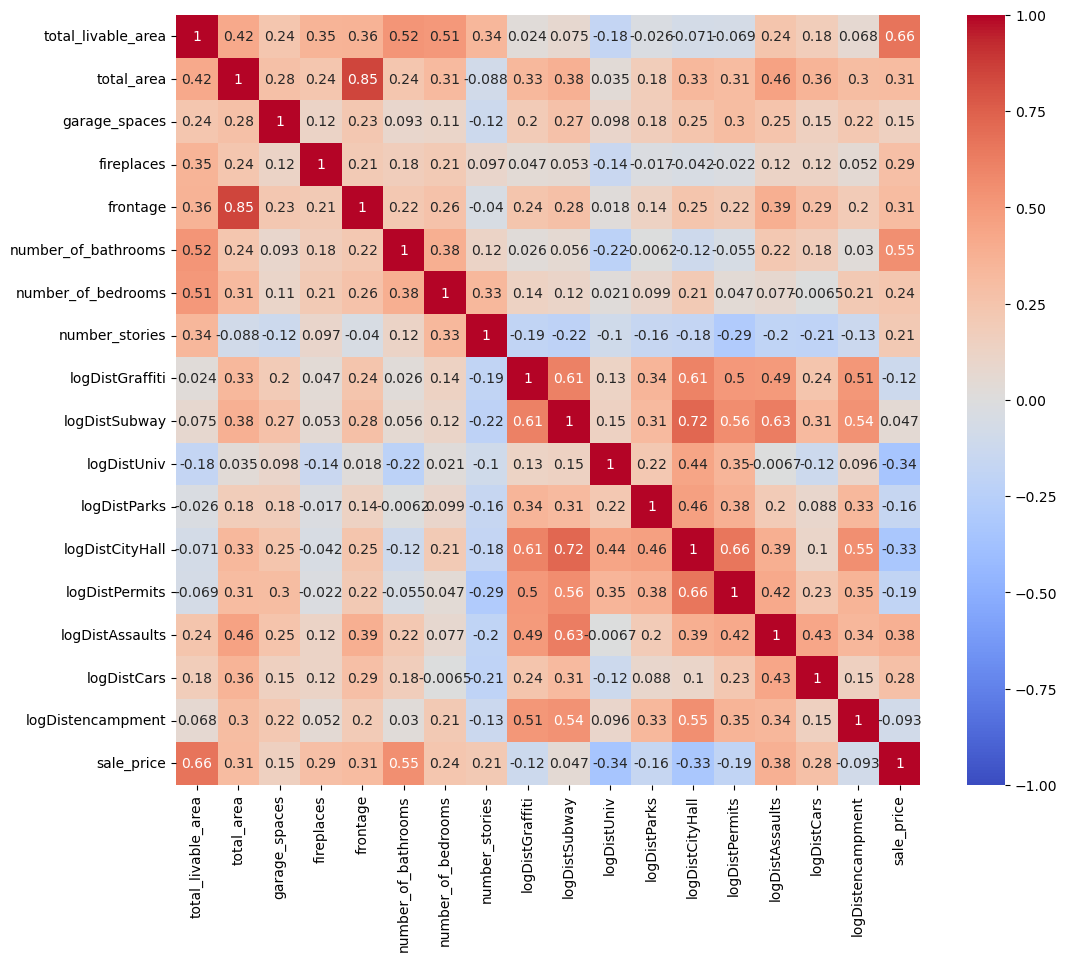

In [87]:
# Numerical columns
cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "fireplaces",
    "frontage",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "logDistGraffiti", 
    "logDistSubway", 
    "logDistUniv", 
    "logDistParks", 
    "logDistCityHall",  
    "logDistPermits", 
    "logDistAssaults", 
    "logDistCars",
    "logDistencampment",
    "sale_price"
]

plt.figure(figsize=(12, 10))
sns.heatmap(sales[cols].corr(), cmap='coolwarm', annot=True, vmin=-1, vmax=1, annot_kws={"size": 10})

plt.show()

### Prediction model result after adding features

#### Set Up Transformer for Numerical and categorical columns:

In [98]:
#| echo: true
#| code-fold: true

# Numerical columns
num_cols = [
    "total_livable_area",
    "total_area",
    "garage_spaces",
    "frontage",
    "fireplaces",
    "number_of_bathrooms",
    "number_of_bedrooms",
    "number_stories",
    "logDistGraffiti",
    "logDistSubway",
    "logDistUniv",
    "logDistParks",
    "logDistCityHall", 
    "logDistPermits",
    "logDistAssaults",
    "logDistCars",
    "logDistencampment"
]

# Categorical columns
cat_cols = ["exterior_condition","interior_condition","zip_code","garage_type","zoning"]

# Set up the column transformer with two transformers
transformer = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ]
)

# Two steps in pipeline: preprocessor and then regressor
pipe = make_pipeline(
    transformer, RandomForestRegressor(n_estimators=20, random_state=42)
)

# Split the data 70/30
train_set, test_set = train_test_split(sales, test_size=0.3, random_state=42)

# the target labels
y_train = np.log(train_set["sale_price"])
y_test = np.log(test_set["sale_price"])

# Fit the training set
pipe.fit(train_set, y_train);

# What's the test score?
pipe.score(test_set, y_test)

0.7897739366605911

### Adding spatial features to the house price model resulted in a score improvement from 0.74 to 0.78

In [97]:
# The one-hot step
ohe = transformer.named_transformers_["cat"]

# One column for each category type!
ohe_cols = ohe.get_feature_names_out()

# Full list of columns is numerical + one-hot
features = num_cols + list(ohe_cols)

# The regressor
regressor = pipe["randomforestregressor"]

# Create the dataframe with importances
importance = pd.DataFrame(
    {"Feature": features, "Importance": regressor.feature_importances_}
)

# Sort importance in descending order and get the top
importance = importance.sort_values("Importance", ascending=False).iloc[:30]

# Plot
importance.hvplot.barh(
    x="Feature", y="Importance", flip_yaxis=True, height=500
)

:Bars   [Feature]   (Importance)